# COVID-19 Analysis - Argentina - 05/09/2020. (R Programming)

### Import the necessary libraries for the analysis.

In [113]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) 
library(forcats)
library(repr)
library(caret)
library(ROCR)
library(grid)
library(CatEncoders)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input/covidargentina/Covid19Casos.csv")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

character(0)

### Import the dataset.

In [114]:
covid <-  as.data.frame(read.csv('../input/covidargentina/Covid19Casos.csv',stringsAsFactors = FALSE, encoding = 'UTF-8'))

### Let's take a look at the dataset.

In [115]:
glimpse(covid)

Rows: 1,339,334
Columns: 25
$ id_evento_caso                   <int> 1000000, 1000002, 1000003, 1000005, …
$ sexo                             <chr> "M", "M", "F", "F", "M", "M", "F", "…
$ edad                             <int> 53, 21, 40, 58, 28, 26, 69, 73, 7, 4…
$ edad_años_meses                  <chr> "Años", "Años", "Años", "Años", "Año…
$ residencia_pais_nombre           <chr> "Argentina", "Argentina", "Argentina…
$ residencia_provincia_nombre      <chr> "CABA", "Buenos Aires", "Córdoba", "…
$ residencia_departamento_nombre   <chr> "SIN ESPECIFICAR", "La Matanza", "Ca…
$ carga_provincia_nombre           <chr> "Buenos Aires", "Buenos Aires", "Cór…
$ fecha_inicio_sintomas            <chr> "", "", "2020-05-24", "", "2020-05-3…
$ fecha_apertura                   <chr> "2020-06-01", "2020-06-01", "2020-06…
$ sepi_apertura                    <int> 23, 23, 23, 23, 23, 23, 23, 23, 23, …
$ fecha_internacion                <chr> "", "", "", "", "", "", "", "", "", …
$ cuidado_intensivo     

### Let's see the provinces of Argentina and test types.

In [116]:
unique(covid$residencia_provincia_nombre) 
unique(covid$clasificacion_resumen)

[1] "CABA"                "Buenos Aires"        "Córdoba"            
 [4] "Mendoza"             "Formosa"             "Santa Fe"           
 [7] "San Luis"            "Entre Ríos"          "Tucumán"            
[10] "Chaco"               "Corrientes"          "Río Negro"          
[13] "La Pampa"            "Santa Cruz"          "Santiago del Estero"
[16] "Neuquén"             "SIN ESPECIFICAR"     "San Juan"           
[19] "Chubut"              "Catamarca"           "Tierra del Fuego"   
[22] "Misiones"            "Jujuy"               "La Rioja"           
[25] "Salta"

[1] "Descartado"     "Sospechoso"     "Confirmado"     "Sin Clasificar"

### We have to replace some values...

In [117]:
covid$clasificacion_resumen[covid$clasificacion_resumen == 'Descartado'] <- 'Negative'
covid$clasificacion_resumen[covid$clasificacion_resumen == 'Sospechoso'] <- 'Suspicious'
covid$clasificacion_resumen[covid$clasificacion_resumen == 'Confirmado'] <- 'Confirmed'
covid$clasificacion_resumen[covid$clasificacion_resumen == 'Sin Clasificar'] <- 'Unclassified'

### ... and change the dates format.

In [118]:
covid$fecha_apertura <- as.Date(covid$fecha_apertura)
covid$fecha_diagnostico <- as.Date(covid$fecha_diagnostico)
covid$fecha_inicio_sintomas <- as.Date(covid$fecha_inicio_sintomas, format = "%Y-%m-%d")
covid$ultima_actualizacion <- as.Date(covid$ultima_actualizacion, format = "%Y-%m-%d")

### Now let's see the quantity of tests per province

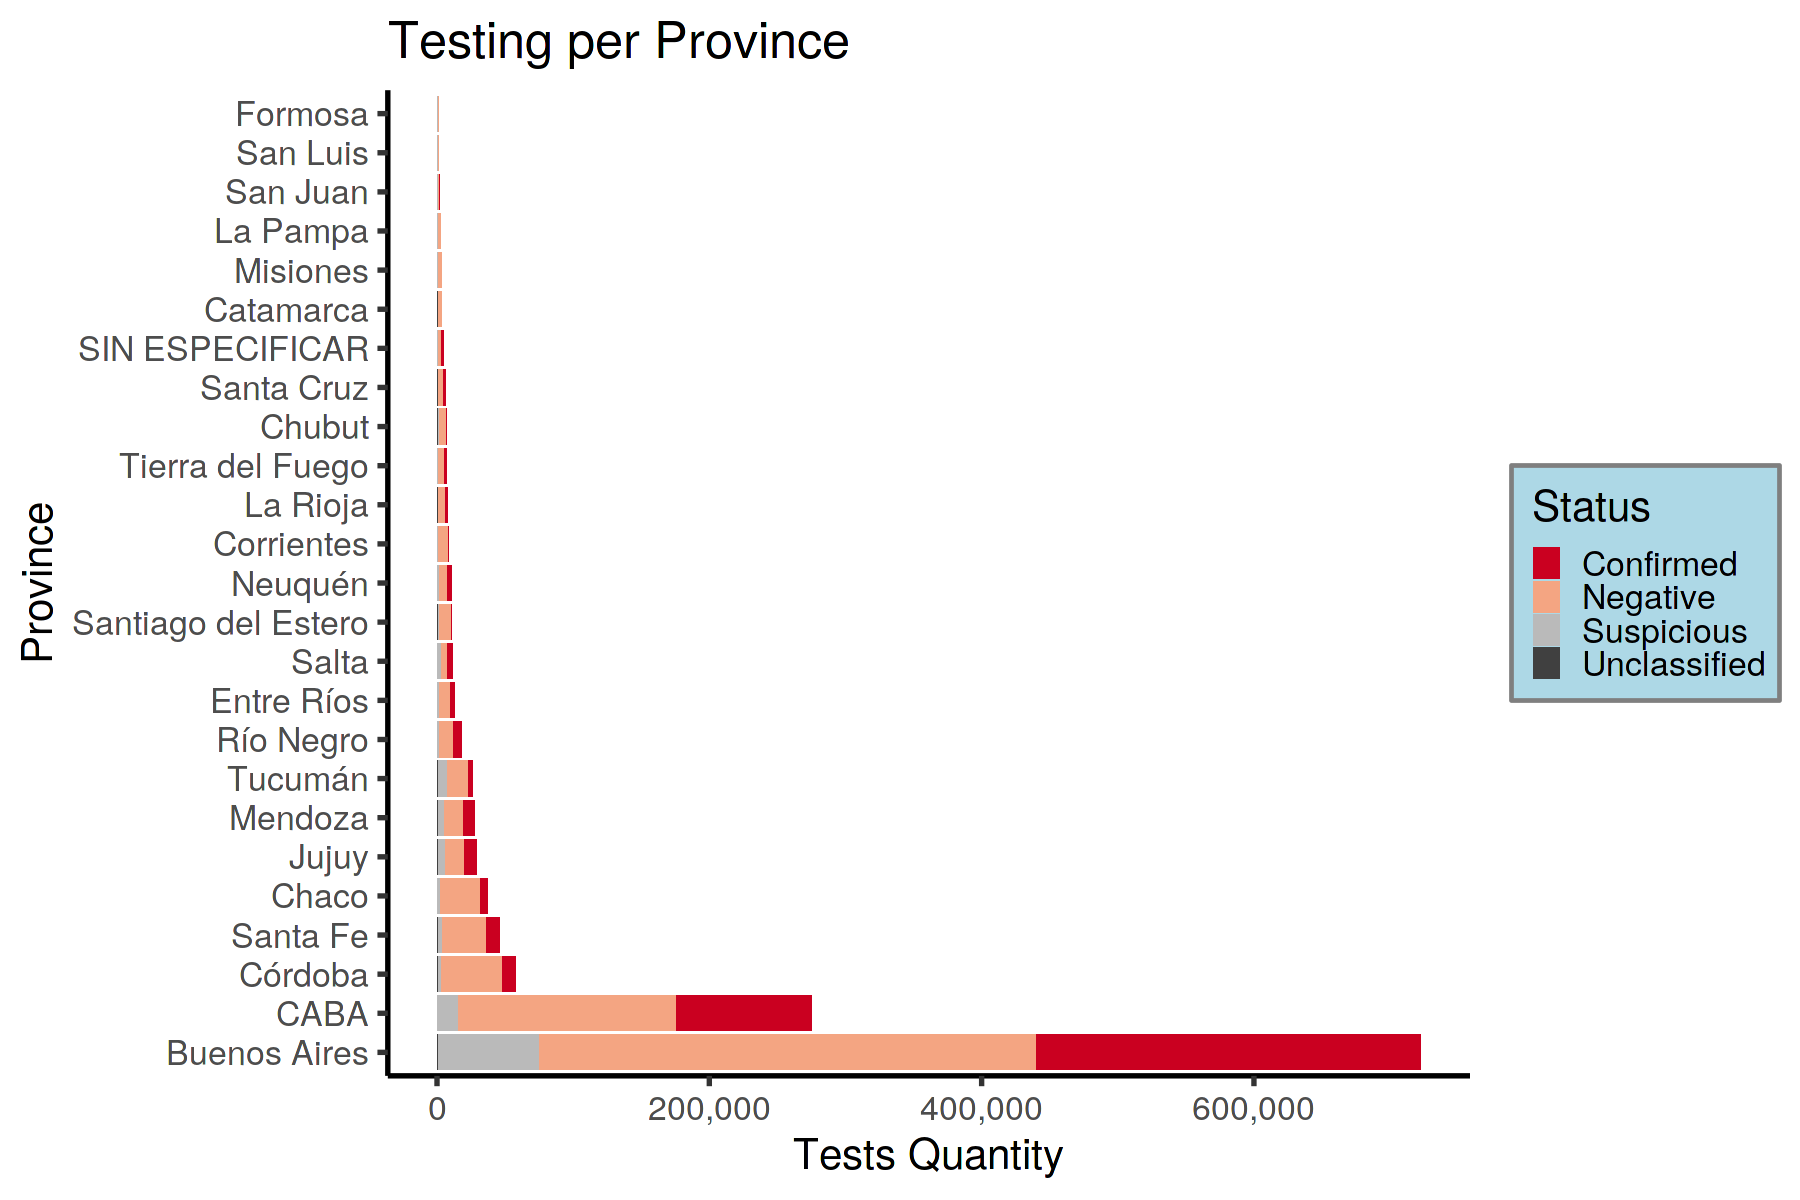

In [119]:
options(repr.plot.width=15, repr.plot.height=10)
theme_set(theme_classic(base_size = 25))

ggplot(covid,aes(x = reorder(residencia_provincia_nombre,residencia_provincia_nombre,function(x)-length(x)),
                             fill=factor(clasificacion_resumen))) +
  geom_bar() +
  scale_fill_brewer(palette = "RdGy")+
  scale_y_continuous(labels = scales::comma, )+
  coord_flip() +
  ggtitle("Testing per Province")+
  xlab("Province") +
  ylab("Tests Quantity") +
  labs(fill = "Status") +
  theme(legend.background = element_rect(fill = "lightblue",colour = "grey50",size = 1))
       


### Perfect, now let's focus on the confirmed cases.

In [120]:
confirmed <- as_tibble(covid %>%
          filter(covid["clasificacion_resumen"] == "Confirmed") %>%
          count(residencia_provincia_nombre, sort = TRUE ))%>%
          rename(Quantity_of_cases = n)

In [121]:
head(confirmed)

residencia_provincia_nombre,Quantity_of_cases
<chr>,<int>
Buenos Aires,282824
CABA,100271
Santa Fe,10806
Córdoba,10335
Jujuy,9547
Mendoza,8798


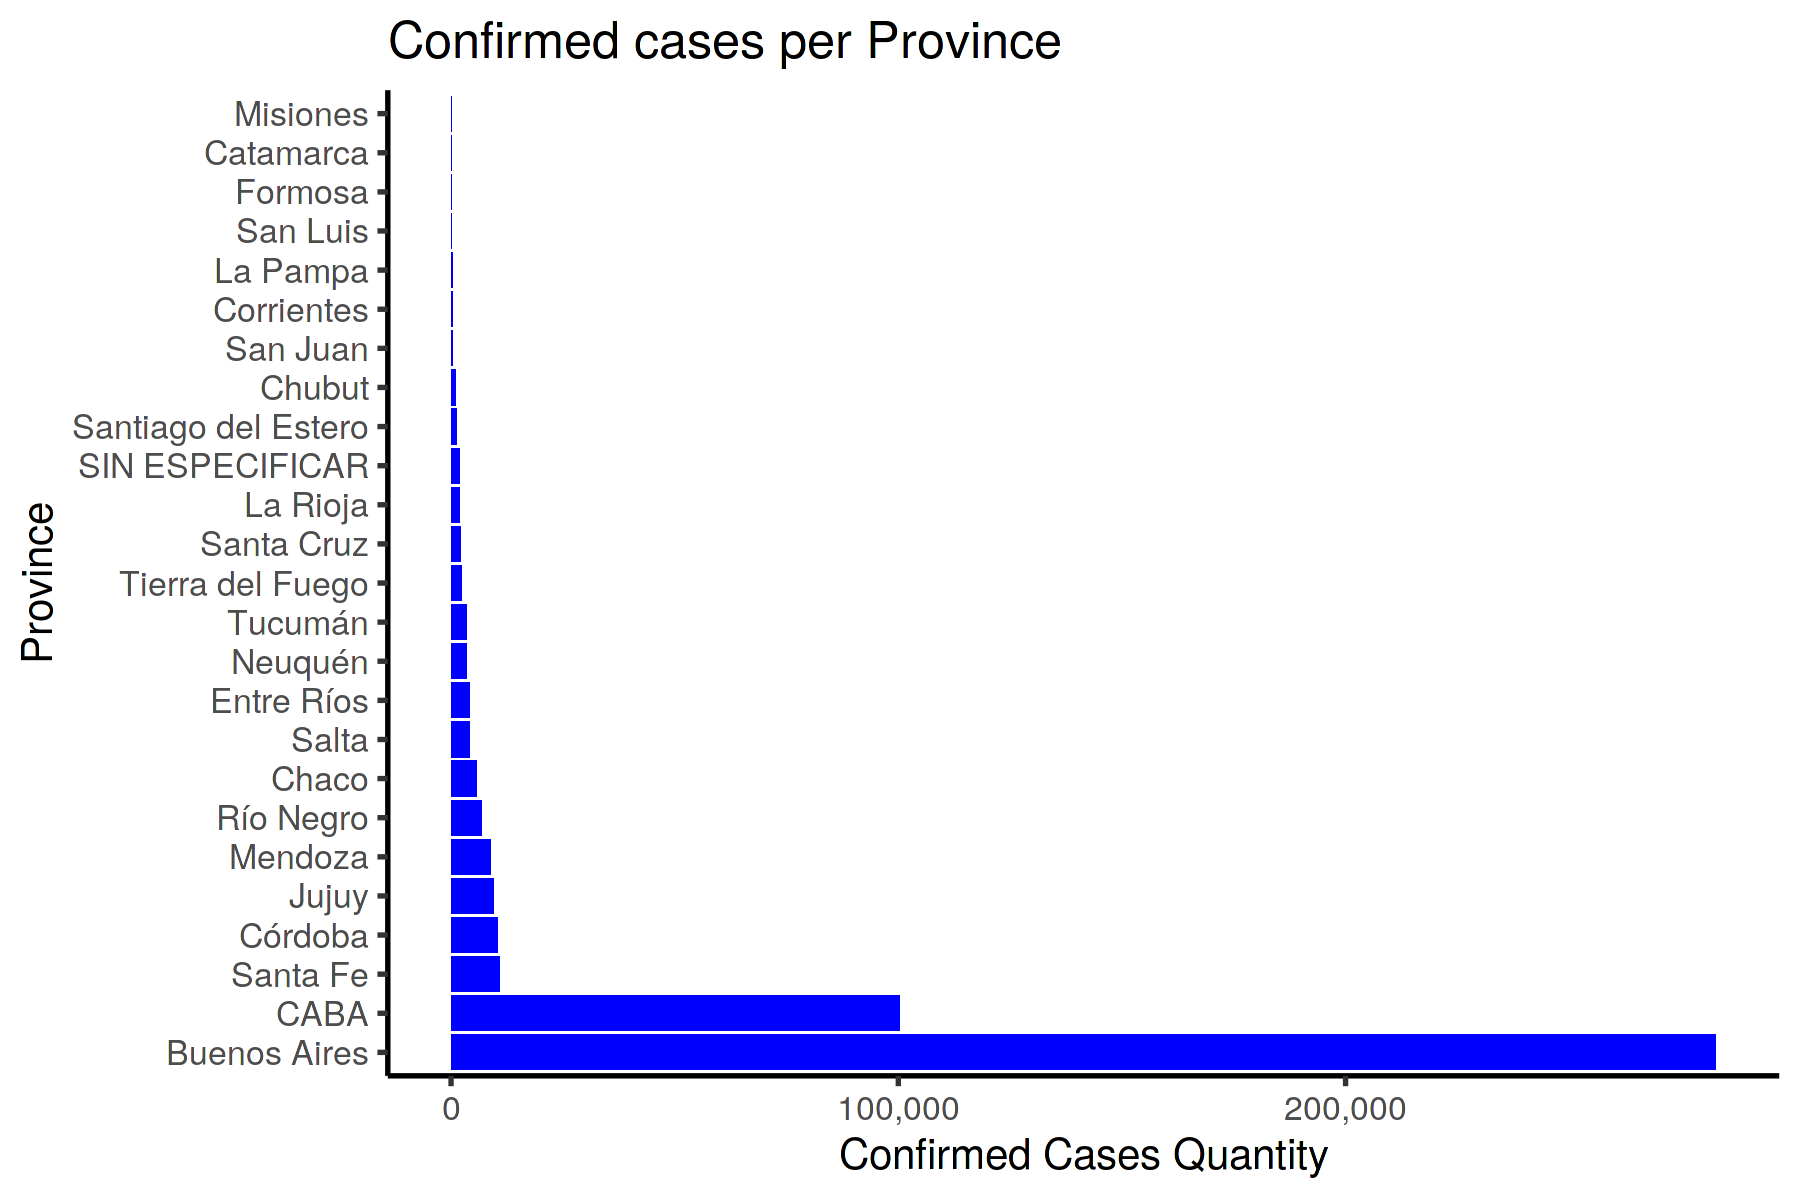

In [122]:
options(repr.plot.width=15, repr.plot.height=10)
theme_set(theme_classic(base_size = 25))

ggplot(confirmed, aes(y= Quantity_of_cases, x = reorder(residencia_provincia_nombre, desc(Quantity_of_cases)))) +
 geom_col(fill='blue') +
 scale_y_continuous(labels = scales::comma)+
 coord_flip() +
 ggtitle("Confirmed cases per Province")+
 xlab("Province") +
 ylab("Confirmed Cases Quantity")


### Now we have to take a look if there are any missing information and format the dates.

In [123]:
sum(is.na(covid$fecha_apertura))
sum(is.na(covid$clasificacion_resumen))

[1] 1

[1] 0

### Let's analyze the "NA" value.

In [124]:
na_value <- covid %>% filter(is.na(covid$fecha_apertura) == TRUE)
na_value

id_evento_caso,sexo,edad,edad_años_meses,residencia_pais_nombre,residencia_provincia_nombre,residencia_departamento_nombre,carga_provincia_nombre,fecha_inicio_sintomas,fecha_apertura,⋯,fecha_fallecimiento,asistencia_respiratoria_mecanica,carga_provincia_id,origen_financiamiento,clasificacion,clasificacion_resumen,residencia_provincia_id,fecha_diagnostico,residencia_departamento_id,ultima_actualizacion
<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<date>,<date>,⋯,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<date>,<int>,<date>
672064,M,52,Años,Argentina,Buenos Aires,Florencio Varela,Buenos Aires,2020-05-29,NA,⋯,,NO,6,Público,Caso Descartado,Negative,6,2020-06-01,274,2020-09-04


#### It seems that the value does not follow the structure of the rest of the dataset.

### Ok, let's see the evolution of cases through time.

Warning message:
“Removed 1 rows containing non-finite values (stat_count).”


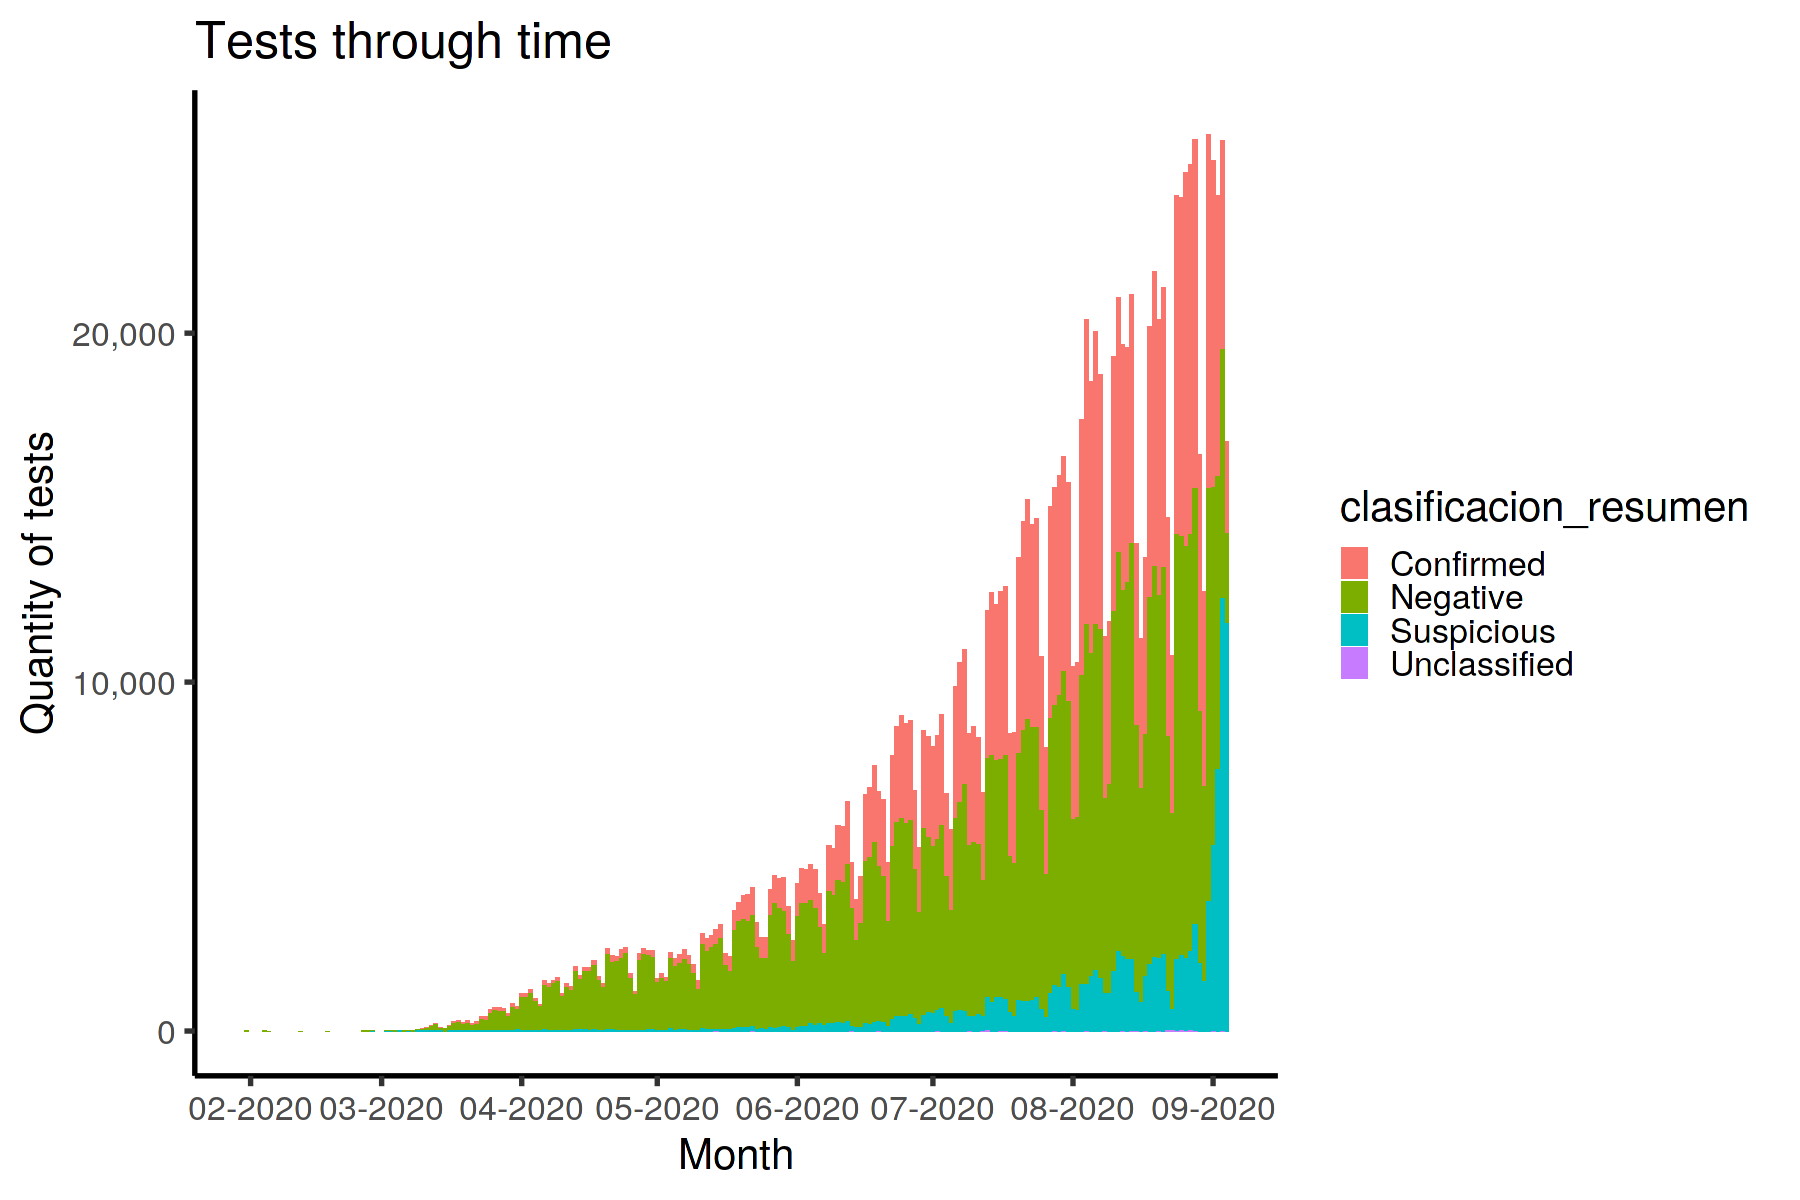

In [125]:
options(repr.plot.width=15, repr.plot.height=10)
theme_set(theme_classic(base_size = 25))

ggplot(covid, aes(x = fecha_apertura ,fill = clasificacion_resumen ))+
  geom_bar() +
  scale_x_date(date_labels = "%m-%Y", date_break = "1 month" )+
  scale_y_continuous(labels = scales::comma)+
  ggtitle("Tests through time")+
  xlab("Month") +
  ylab("Quantity of tests")


### Now let's remove the 'Suspicious' cases and take a look again.

In [126]:
non_suspicious <- covid %>% filter(clasificacion_resumen != 'Suspicious')

Warning message:
“Removed 1 rows containing non-finite values (stat_density).”


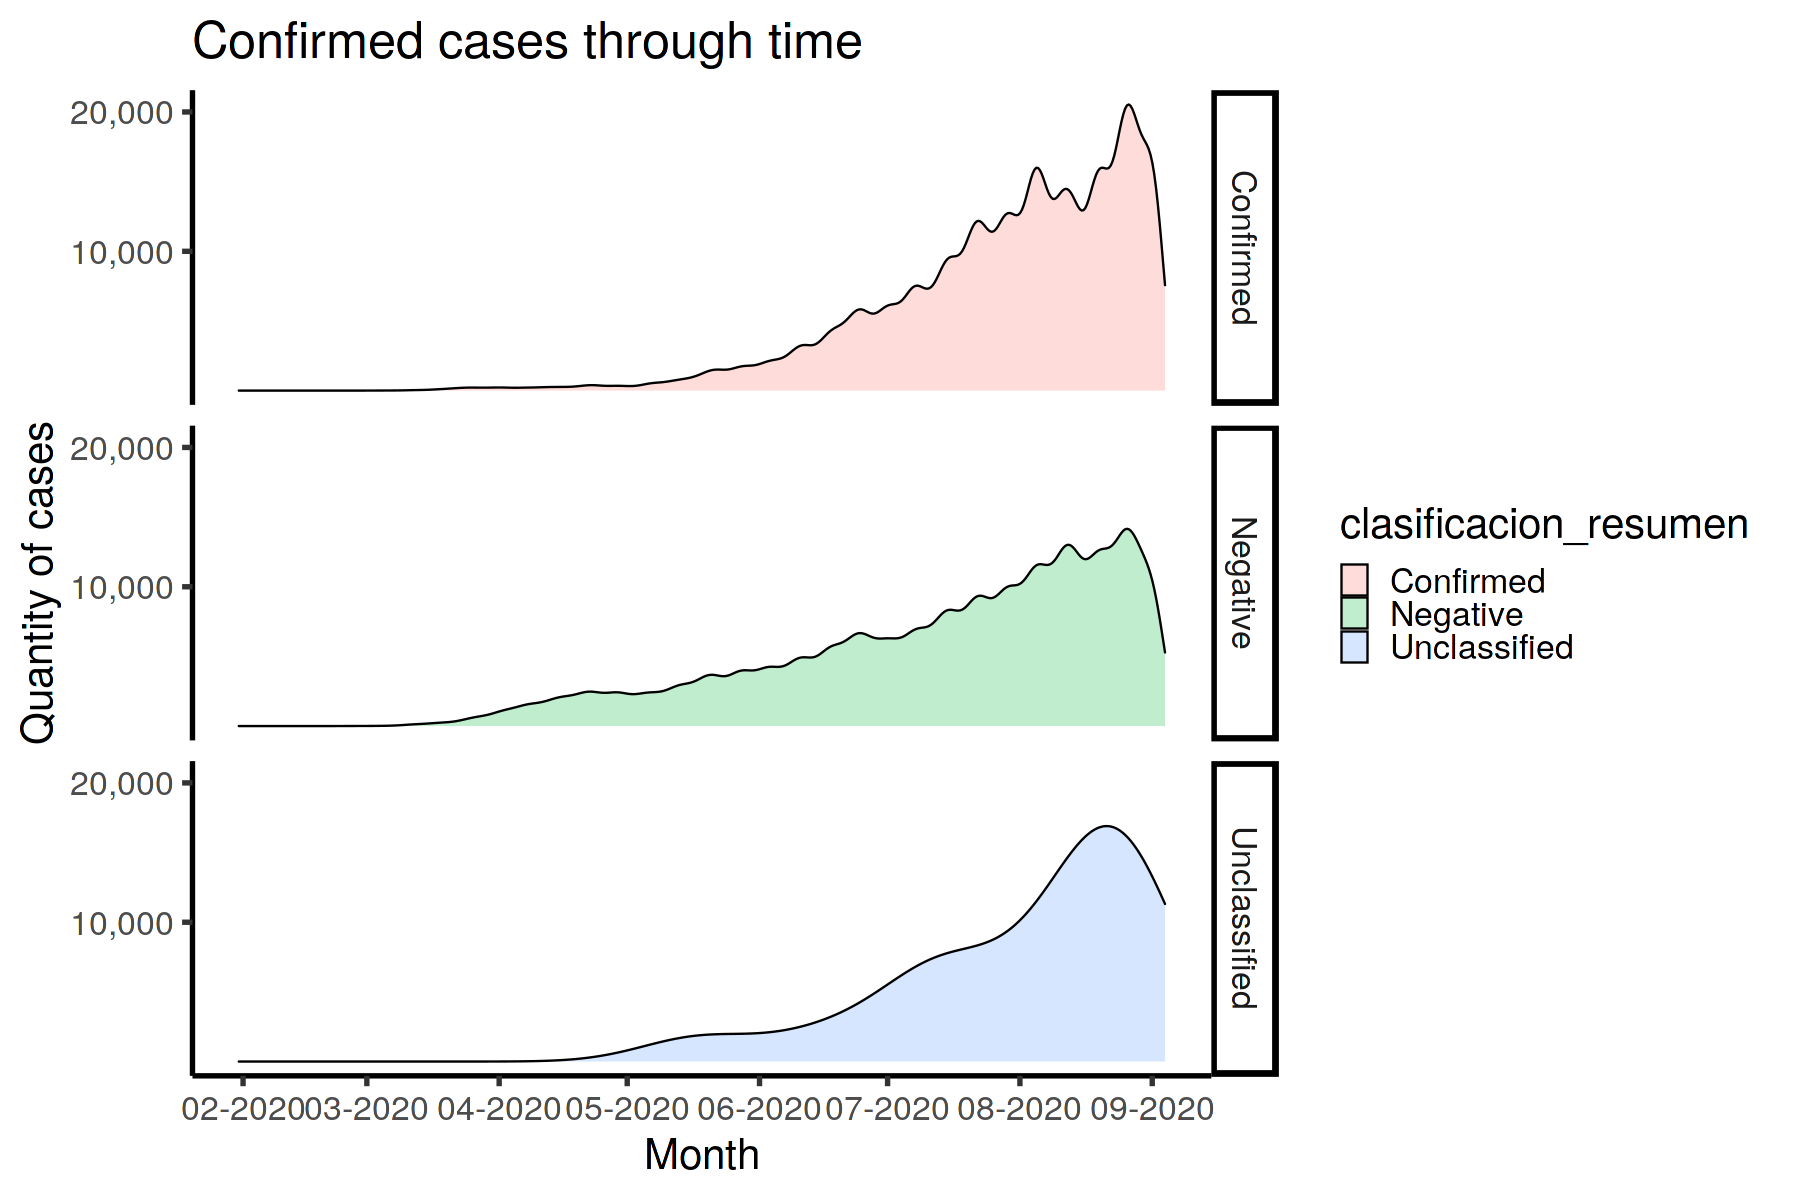

In [127]:
options(repr.plot.width=15, repr.plot.height=10)
theme_set(theme_classic(base_size = 25))

ggplot(non_suspicious, aes(x = fecha_apertura ,fill = clasificacion_resumen))+
  geom_density(alpha = 0.25) +
  facet_grid(clasificacion_resumen ~.)+
  scale_x_date(date_labels = "%m-%Y", date_break = "1 month" )+
  scale_y_continuous(breaks = c(0.01, 0.02), labels = c("10,000", "20,000"))+
  ggtitle("Confirmed cases through time")+
  xlab("Month") +
  ylab("Quantity of cases")

### Let's analyze now the quantity of deaths through time.

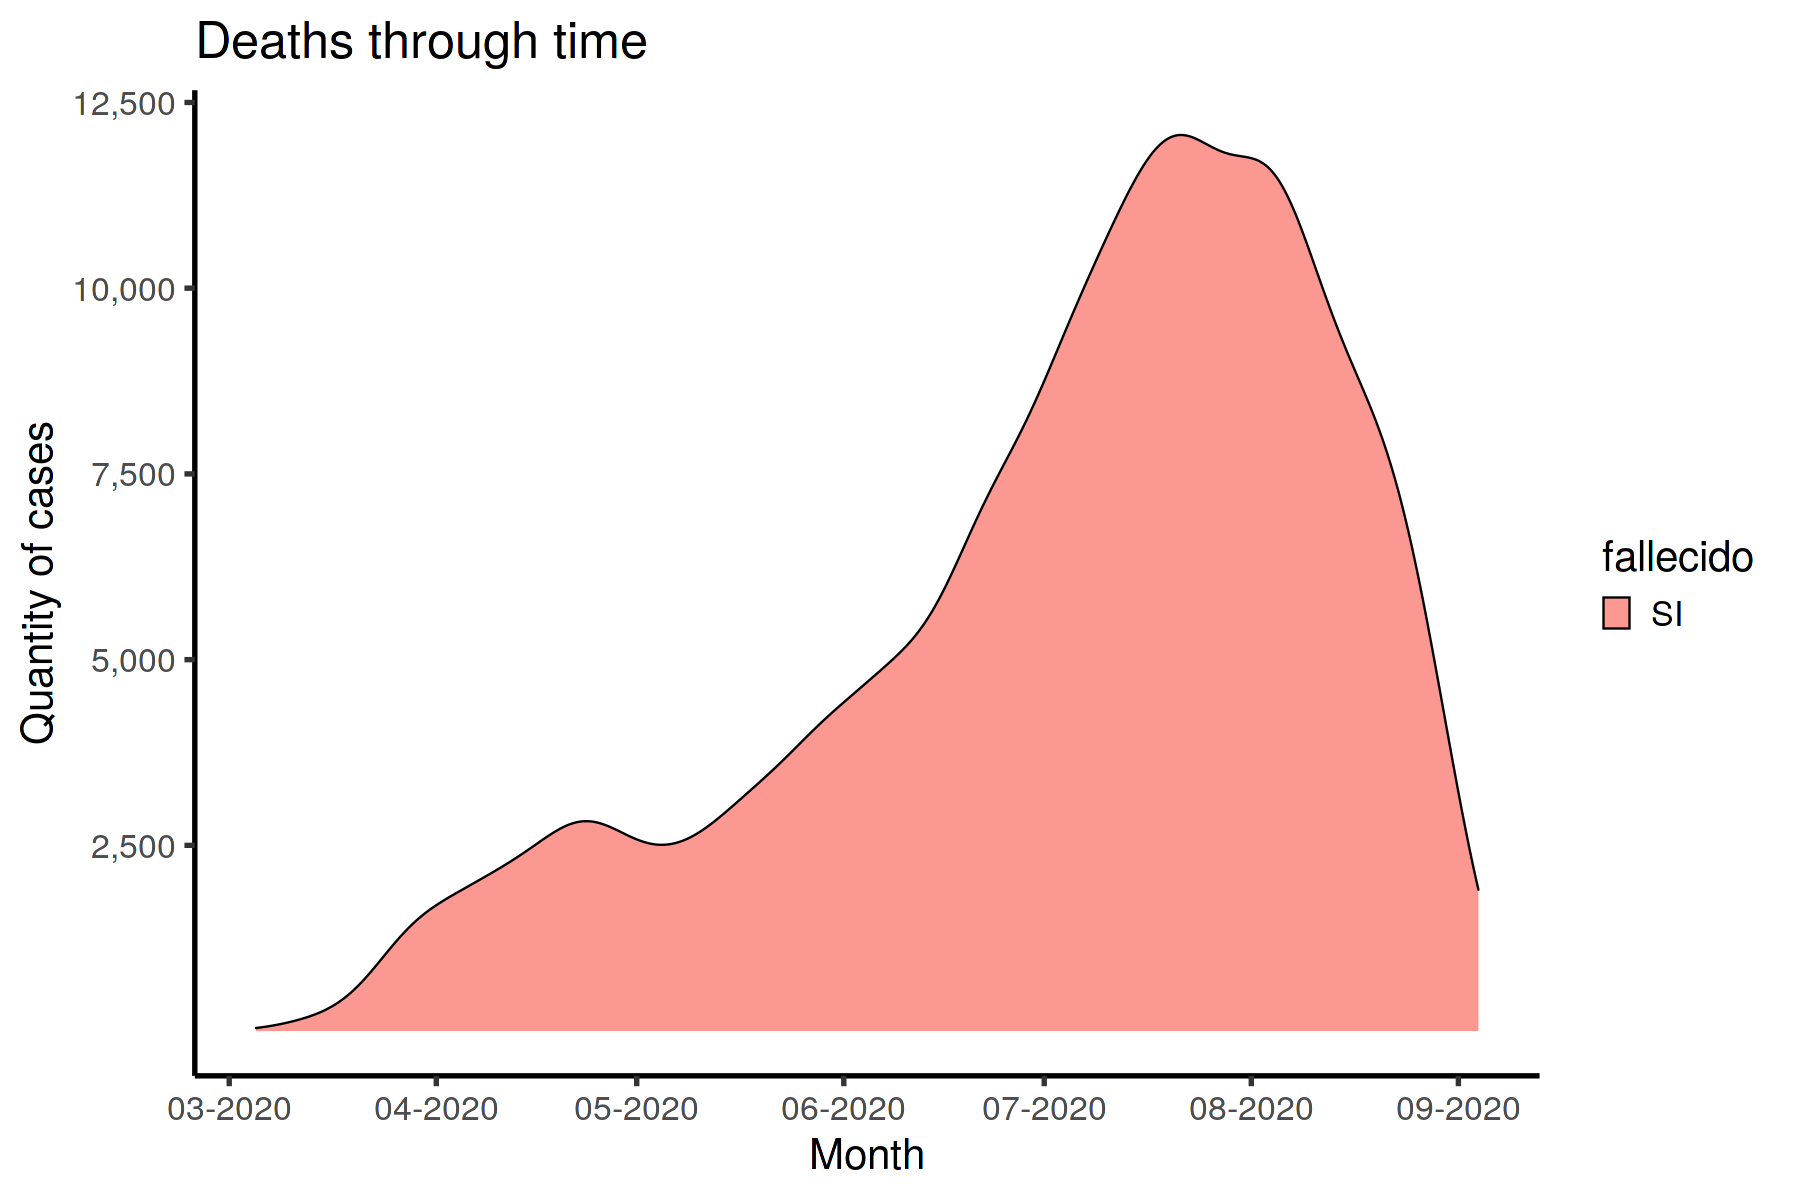

In [128]:
death <- covid %>% filter(fallecido == "SI")

options(repr.plot.width=15, repr.plot.height=10)
theme_set(theme_classic(base_size = 25))

ggplot(death, aes(x = fecha_apertura ,fill = fallecido))+
  geom_density(alpha = 0.75) +
  scale_x_date(date_labels = "%m-%Y", date_break = "1 month" )+
  scale_y_continuous(breaks = c(0.0025, 0.005,0.0075,0.01,0.0125), labels = c("2,500","5,000","7,500","10,000","12,500"))+
  ggtitle("Deaths through time")+
  xlab("Month") +
  ylab("Quantity of cases")

### And finally, let's see the evolution of ventilators needed through time.

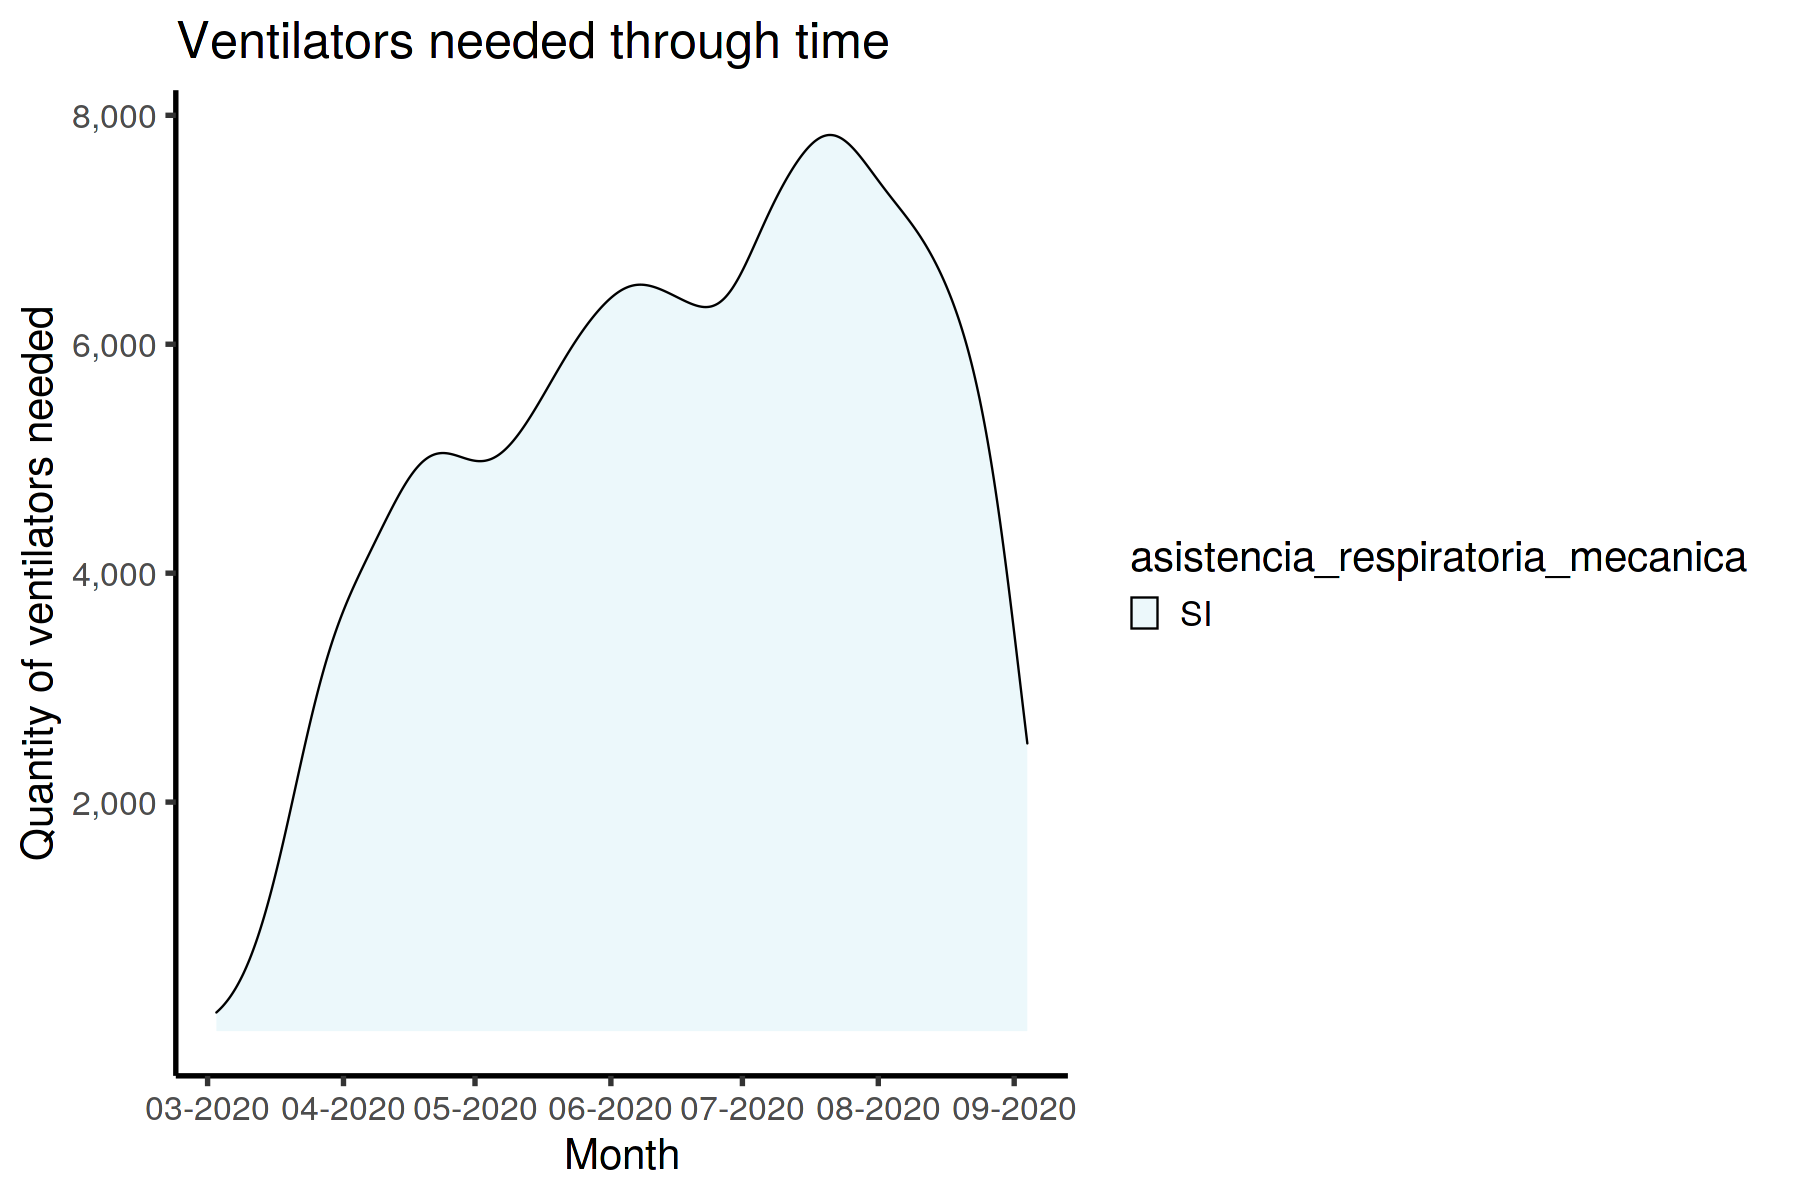

In [129]:
ventilator <- covid %>% filter(asistencia_respiratoria_mecanica == "SI")

options(repr.plot.width=15, repr.plot.height=10)
theme_set(theme_classic(base_size = 25))

ggplot(ventilator, aes(x = fecha_apertura ,fill = asistencia_respiratoria_mecanica))+
  geom_density(alpha = 0.75) +
  scale_x_date(date_labels = "%m-%Y", date_break = "1 month" )+
  scale_y_continuous(breaks = c(0.002, 0.004,0.006,0.008), labels = c("2,000","4,000","6,000","8,000"))+
  ggtitle("Ventilators needed through time")+
  xlab("Month") +
  ylab("Quantity of ventilators needed") +
  scale_fill_brewer(palette = "BuGn")

## Data Preparation

### Now we are going to run a logistic regression in order to predict if people with certain characteristics will survive COVID or if they will not. First of all, let's select only the relevant elements for the model and creat a new dataframe.

In [130]:
covid_analisis <- covid %>% select('fallecido',
                                   'sexo',
                                   #'residencia_provincia_nombre',
                                   'origen_financiamiento',
                                   'asistencia_respiratoria_mecanica',
                                   'edad') 
glimpse(covid_analisis)


Rows: 1,339,334
Columns: 5
$ fallecido                        <chr> "NO", "NO", "NO", "NO", "NO", "NO", …
$ sexo                             <chr> "M", "M", "F", "F", "M", "M", "F", "…
$ origen_financiamiento            <chr> "Privado", "Público", "Privado", "Pú…
$ asistencia_respiratoria_mecanica <chr> "NO", "NO", "NO", "NO", "NO", "NO", …
$ edad                             <int> 53, 21, 40, 58, 28, 26, 69, 73, 7, 4…


In [131]:
covid_analisis$fallecido[covid_analisis$fallecido == 'NO'] <- 0
covid_analisis$fallecido[covid_analisis$fallecido == 'SI'] <- 1

In [132]:
for(i in 1:ncol(covid_analisis)){
  covid_analisis[is.na(covid_analisis[,i]), i] <- mean(covid_analisis[,i], na.rm = TRUE)
}

Warning message in mean.default(covid_analisis[, i], na.rm = TRUE):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(covid_analisis[, i], na.rm = TRUE):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(covid_analisis[, i], na.rm = TRUE):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(covid_analisis[, i], na.rm = TRUE):
“argument is not numeric or logical: returning NA”


In [133]:
covid_analisis$fallecido  <- as.factor(covid_analisis$fallecido)
covid_analisis$sexo <- as.factor(covid_analisis$sexo)
#covid_analisis$residencia_provincia_nombre <- as.factor(covid_analisis$residencia_provincia_nombre )
covid_analisis$origen_financiamiento <- as.factor(covid_analisis$origen_financiamiento)
covid_analisis$asistencia_respiratoria_mecanica  <- as.factor(covid_analisis$asistencia_respiratoria_mecanica)
covid_analisis$edad  <- as.integer(covid_analisis$edad)

In [134]:
x <- 'fallecido'
y <- c('sexo',
       'residencia_provincia_nombre',
       'origen_financiamiento',
       'asistencia_respiratoria_mecanica',
       'edad')

In [135]:
# set seed for reproducibility
set.seed(123)

# making a train index
train_index <- sample(c(TRUE, FALSE), replace = TRUE, size = nrow(covid_analisis), prob = c(0.2, 0.8))

# split the data according to the train index
train <- as.data.frame(covid_analisis[train_index, ])
test <- as.data.frame(covid_analisis[!train_index, ])

In [136]:
model <- glm(fallecido ~ . , data = train, family = binomial(link = 'logit'))

[1] 0.0 0.9
[1] 0.00210872


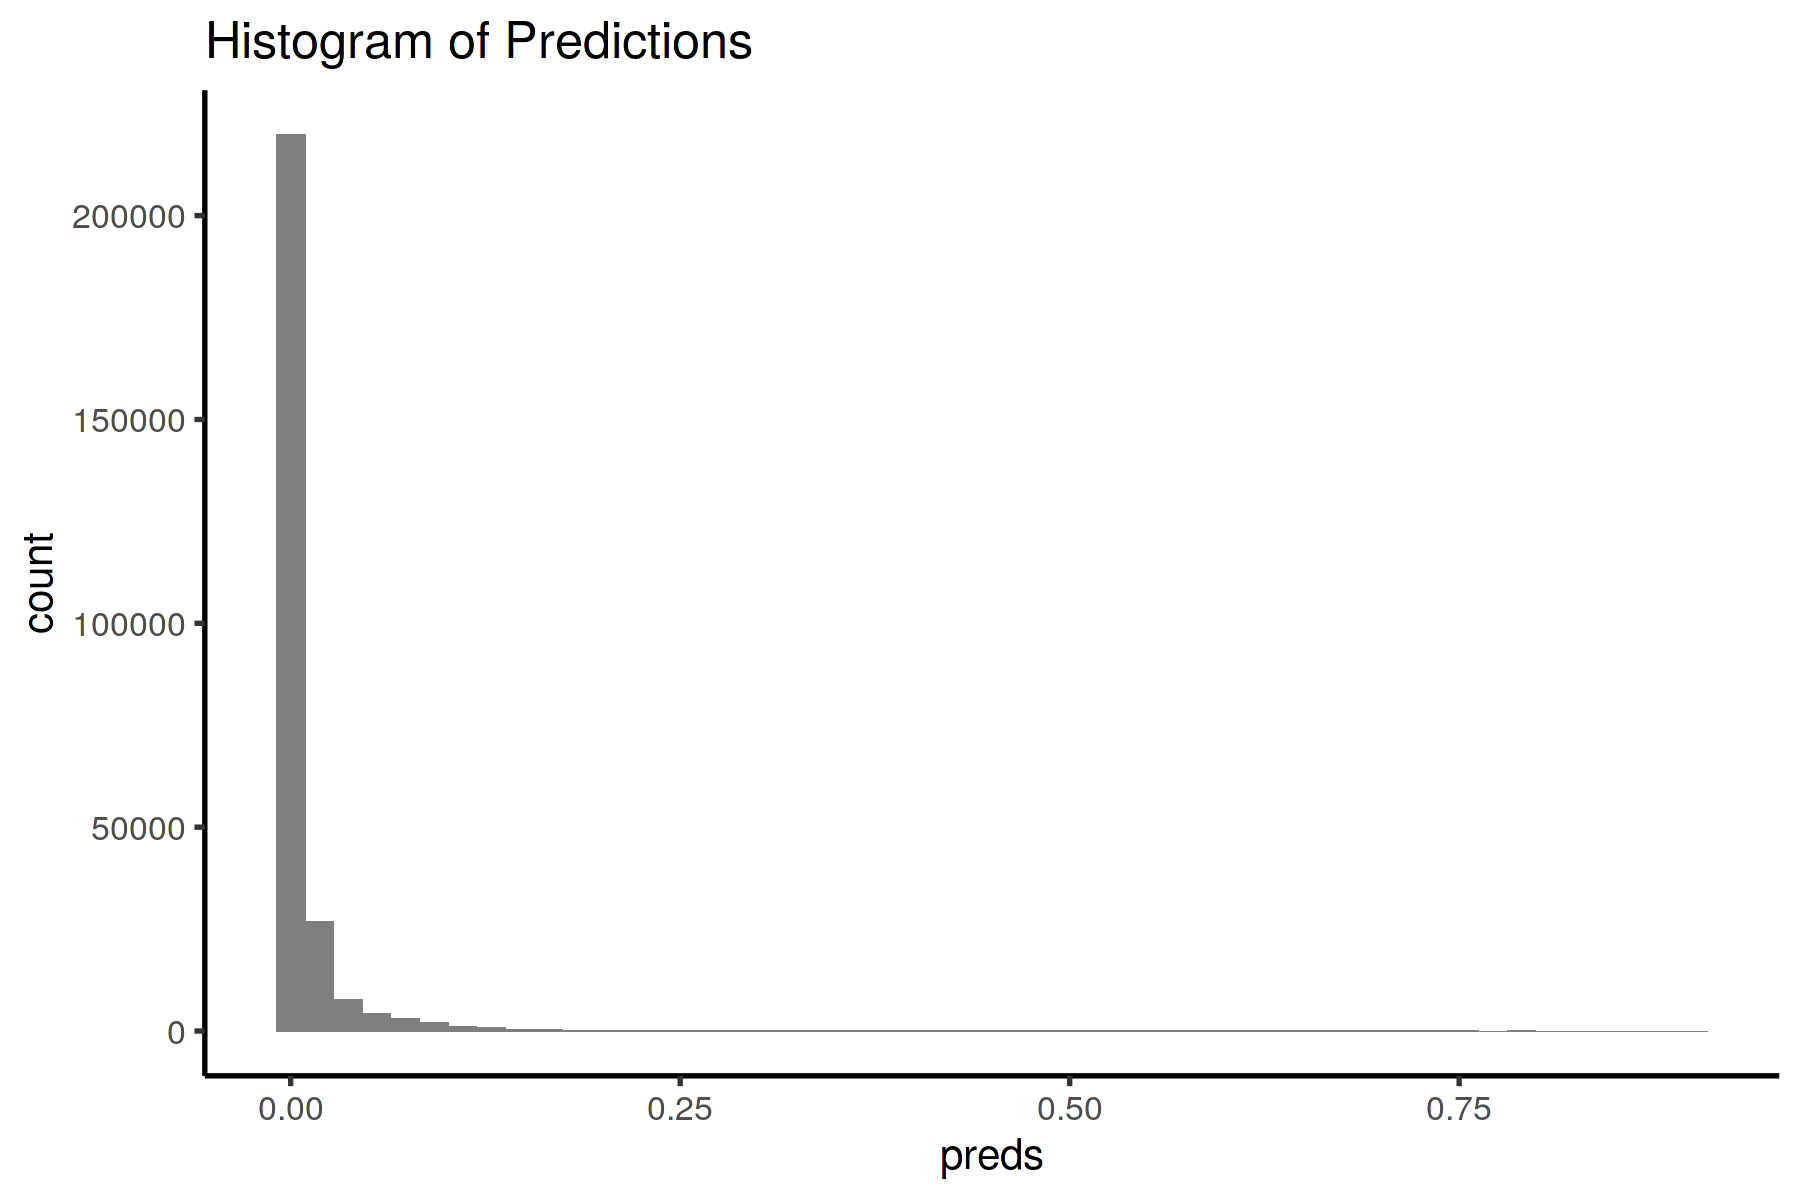

In [137]:
options(repr.plot.width=15, repr.plot.height=10)
theme_set(theme_classic(base_size = 25))

# make predictions on the test set
train$pred <- predict(model, newdata=train, type="response")
test$pred <- predict(model, newdata=test, type="response")

# plot histogram of predictions
data.frame(preds <- train$pred ) %>%
    ggplot(aes(x = preds)) + 
    geom_histogram(bins = 50, fill = 'grey50') +
    labs(title = 'Histogram of Predictions') 

# print range of predictions
print(round(range(train$pred),2))

# print median of predictions
print(median(train$pred))


In [138]:
predObj <- prediction(train$pred, train$fallecido)
precObj <- performance(predObj, measure="prec")
recObj <- performance(predObj, measure="rec")

In [149]:
precision <- (precObj@y.values)[[1]]
prec.x <- (precObj@x.values)[[1]]
recall <- (recObj@y.values)[[1]]

Warning message:
“Removed 1 row(s) containing missing values (geom_path).”


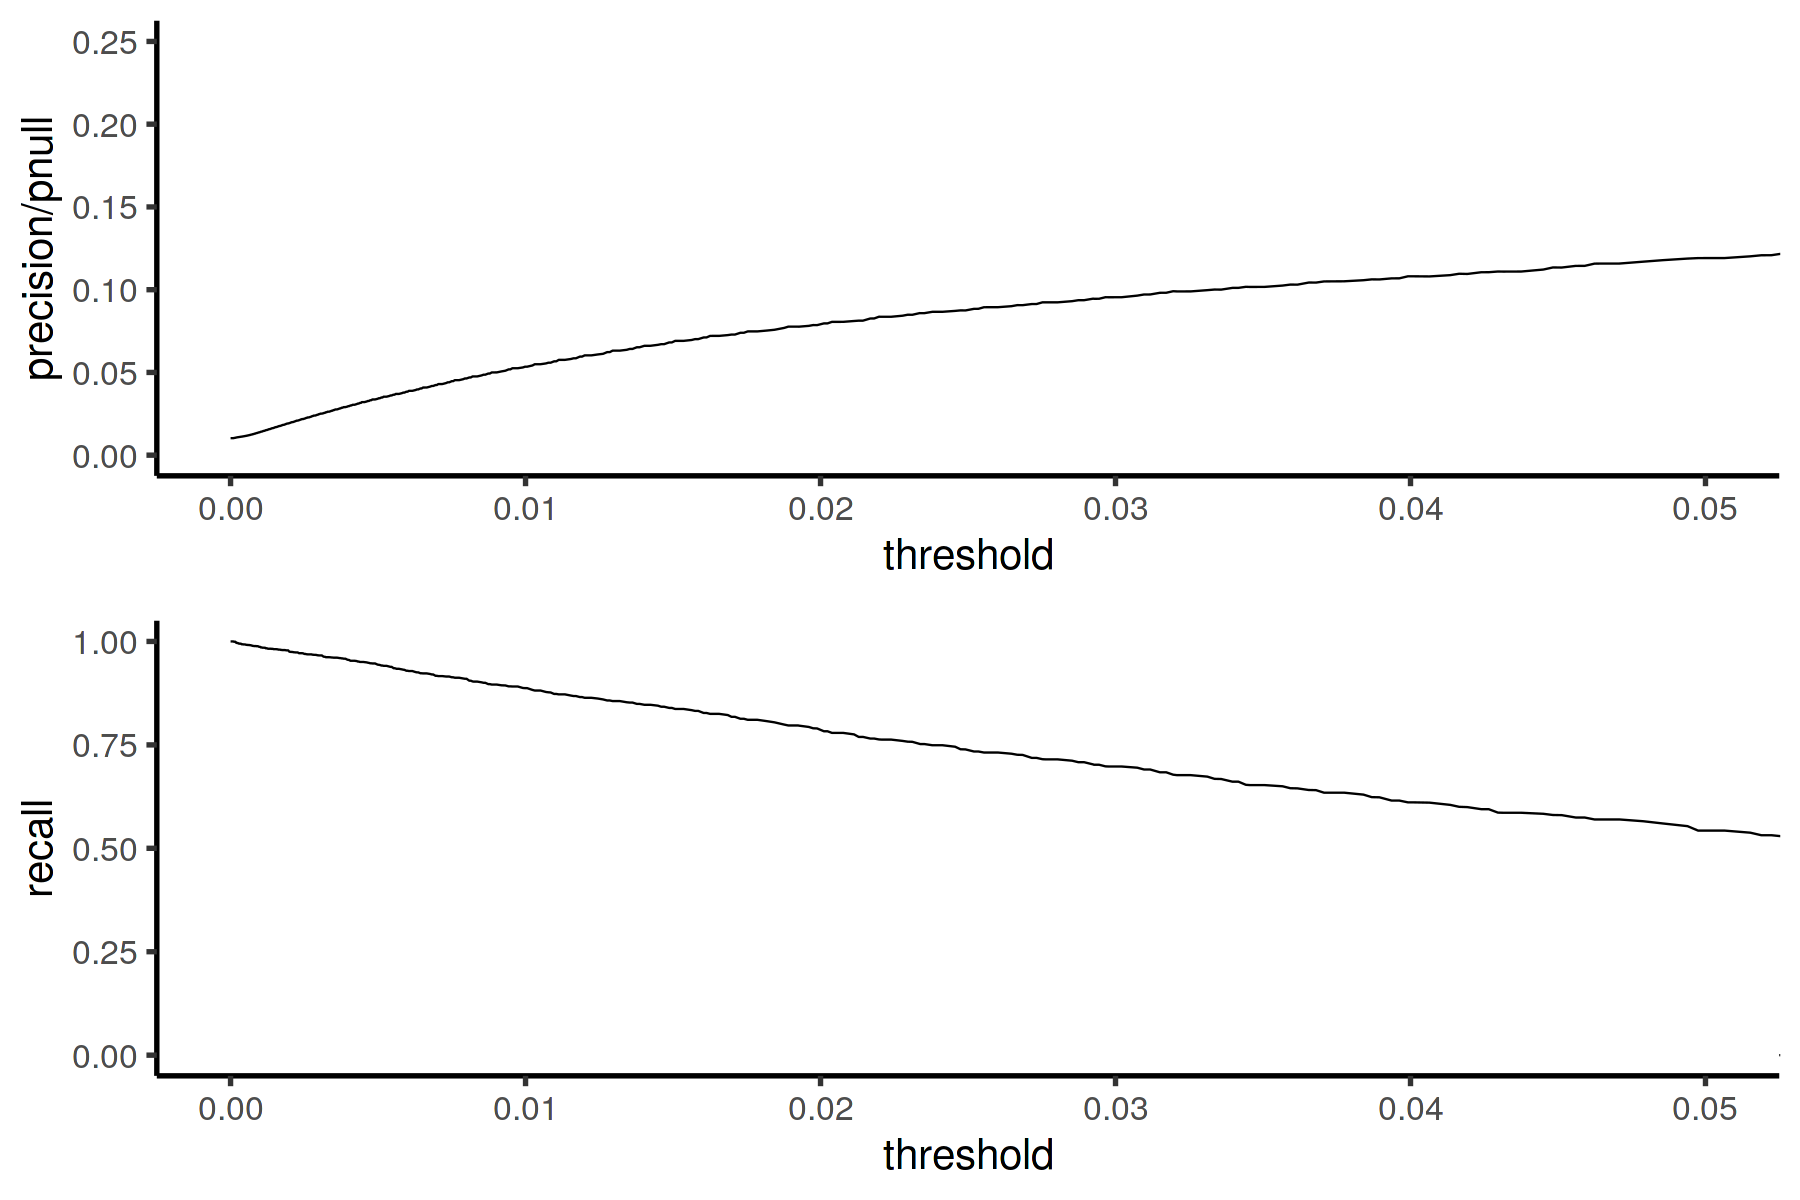

In [150]:
rocFrame <- data.frame(threshold=prec.x, precision=precision,recall=recall)
nplot <- function(plist) {
                           n <- length(plist)
                           grid.newpage()
                           pushViewport(viewport(layout=grid.layout(n,1)))
                           vplayout=function(x,y) {viewport(layout.pos.row=x, layout.pos.col=y)}
                           for(i in 1:n) {
                           print(plist[[i]], vp=vplayout(i,1))
                                         }
                          }
pnull <-mean(as.numeric(train$fallecido))

p1 <- ggplot(rocFrame, aes(x=threshold)) +
      geom_line(aes(y=precision/pnull)) +
      coord_cartesian(xlim = c(0,0.05), ylim=c(0,0.25) )
     
p2 <- ggplot(rocFrame, aes(x=threshold)) +
      geom_line(aes(y=recall)) +
      coord_cartesian(xlim = c(0,0.05) )
      
nplot(list(p1, p2))

In [141]:
ctab.test <- table(pred=test$pred>0.02, fallecido =test$fallecido)
ctab.test

precision <- ctab.test[2,2]/sum(ctab.test[2,])
precision

recall <- ctab.test[2,2]/sum(ctab.test[,2])
recall

enrich <- precision/mean(as.numeric(test$fallecido))
enrich

       fallecido
pred         0      1
  FALSE 961070   2582
  TRUE   99205   8489

[1] 0.07882519

[1] 0.7667781

[1] 0.07801896

In [142]:
preds <- predict(model, newdata = test, type = "response")

roc_data <- data.frame(
    p0.3 = ifelse(preds > 0.3, 1, 0),
    p0.2 = ifelse(preds > 0.2, 1, 0),
    p0.1 = ifelse(preds > 0.1, 1, 0),
    p0.05 = ifelse(preds > 0.05, 1, 0),
    p0.04 = ifelse(preds > 0.04, 1, 0),
    p0.03 = ifelse(preds > 0.03, 1, 0),
    p0.02 = ifelse(preds > 0.02, 1, 0),
    p0.01 = ifelse(preds > 0.01, 1, 0))

In [143]:
# true positive (hit) rate
tpr <- function(pred, actual) {
    res <- data.frame(pred, actual)
    sum(res$actual == 1 & res$pred == 1) / sum(actual == 1)
}

# false positive rate
fpr <- function(pred, actual) {
    res <- data.frame(pred, actual)
    sum(res$actual == 0 & res$pred == 1) / sum(actual == 0)
}

In [144]:
actual <- test$fallecido

In [145]:
# reshape to long format and get fpr and tpr for each threshold
roc_data <- roc_data %>% 
    gather(key = 'threshold', value = 'pred') %>% 
    group_by(threshold) %>%
    summarize(tpr = tpr(pred, actual = actual), 
              fpr = fpr(pred, actual = actual))

`summarise()` ungrouping output (override with `.groups` argument)



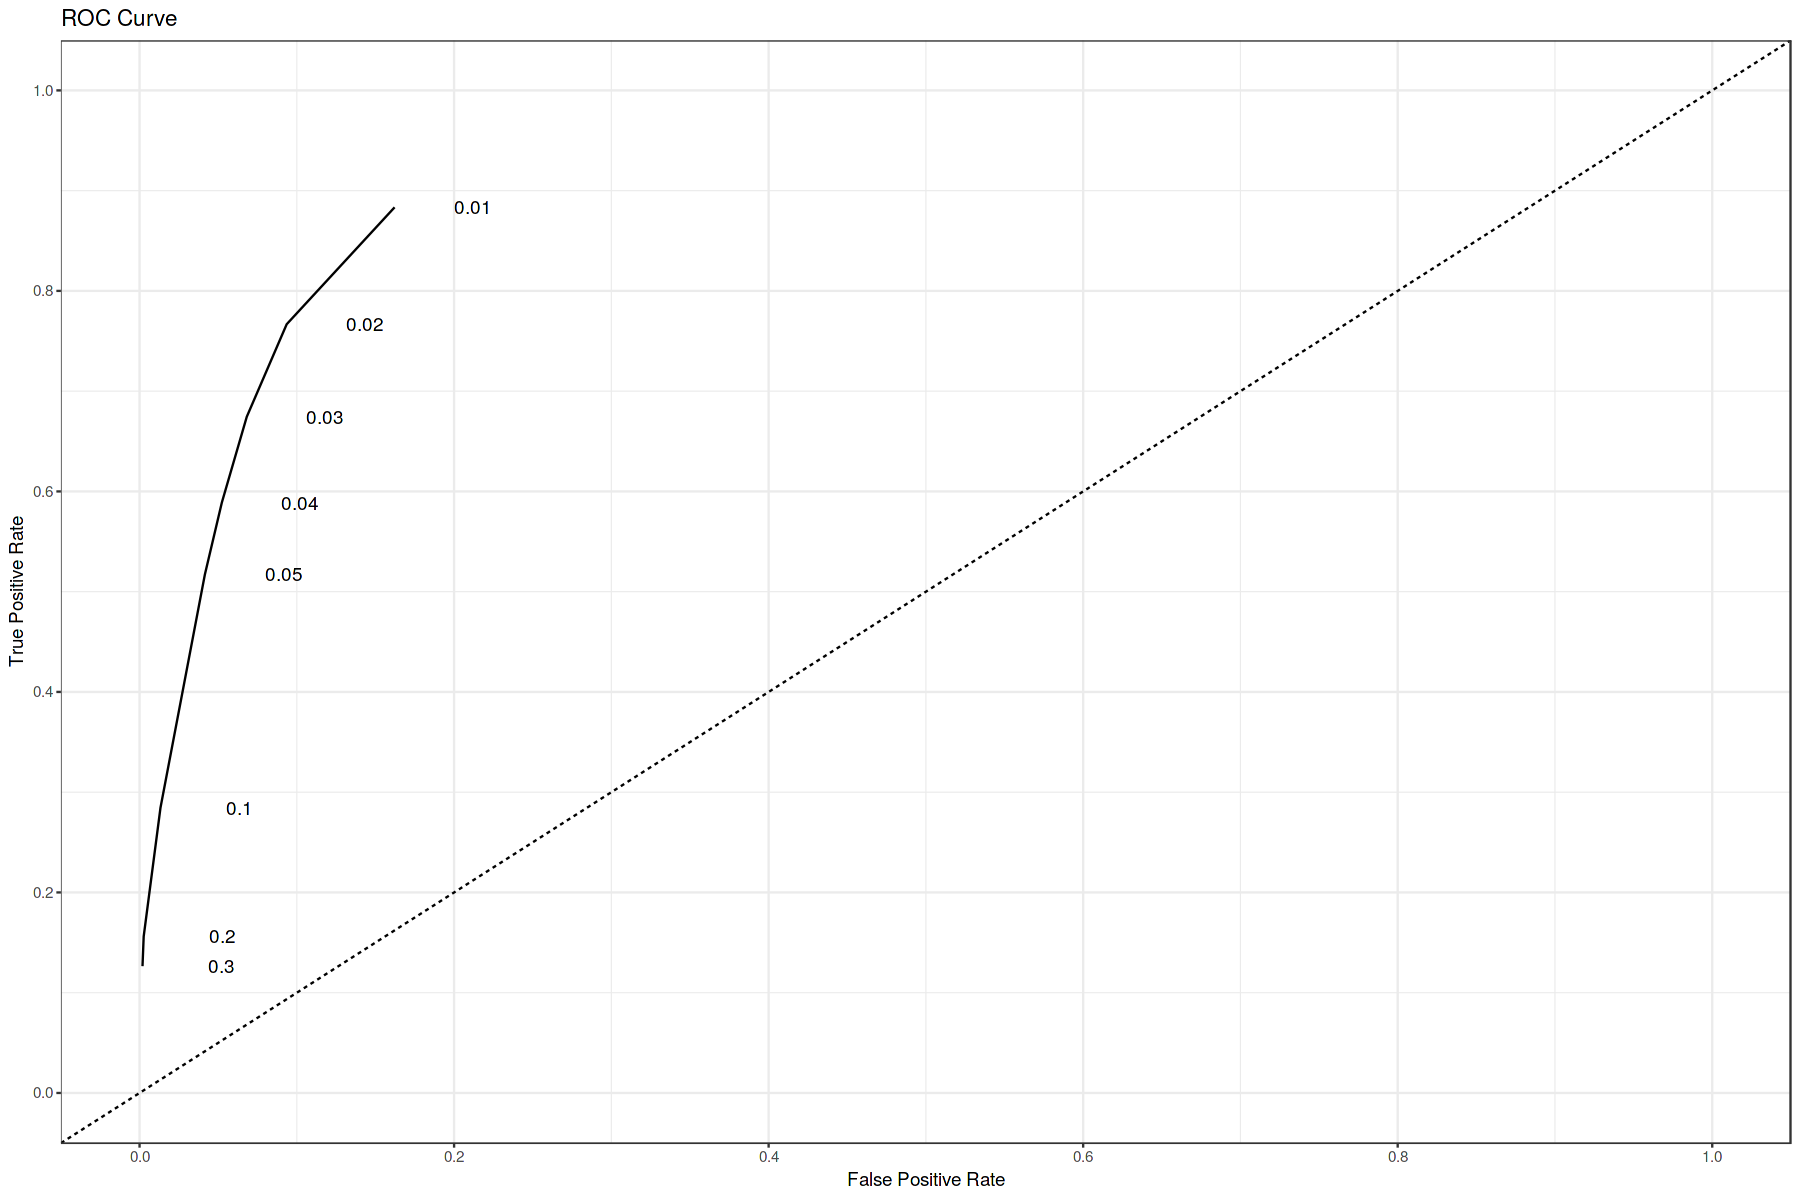

In [146]:
# set x and y tick marks
breaks <-  c(0, 0.2, 0.4, 0.6, 0.8, 1)

# get labels for plotting break points
labels <- substr(roc_data$threshold, start = 2, stop = 5)

# plot the ROC curve
ggplot(data = roc_data, aes(x = fpr, y = tpr)) + 
    geom_line() + 
    geom_text(aes(label = labels), nudge_x = 0.05) + 
    geom_abline(intercept = 0, slope = 1, linetype = 'dashed') + 
    scale_x_continuous(limits = c(0, 1), breaks = breaks) + 
    scale_y_continuous(limits = c(0,1), breaks = breaks) + 
    labs(x = 'False Positive Rate', y = 'True Positive Rate', title = 'ROC Curve') 

In [147]:
summary(model)


Call:
glm(formula = fallecido ~ ., family = binomial(link = "logit"), 
    data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1475  -0.1056  -0.0635  -0.0419   4.3154  

Coefficients:
                                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)                        -16.244570  78.612305  -0.207    0.836    
sexoM                                0.493682   0.042085  11.730   <2e-16 ***
sexoNR                               0.197942   0.282140   0.702    0.483    
origen_financiamientoPrivado         7.027918  78.612279   0.089    0.929    
origen_financiamientoPúblico         6.933132  78.612278   0.088    0.930    
asistencia_respiratoria_mecanicaSI   3.408000   0.066123  51.541   <2e-16 ***
edad                                 0.076875   0.001126  68.255   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 30950  on 26